# BatchNorm1D

Batch Nom standardizes x in simple way like Standard Scalar but it also changes
y as y =γ.x + β.

---

*   γ = scale default = 1
*   β = shift default = 0

we are using axis =0 because all operations here are done along batch dimension

 Example : x.shape = (32,8) # batch of 32 samples,each with 8 features
 then mu.shape = (1,8) Mean per feature

In BatchNorm2D normalization is done per channel resulting in mu and var of shape (1,C,1,1).

---
You want all neurons within the same feature map to be on a similar scale.



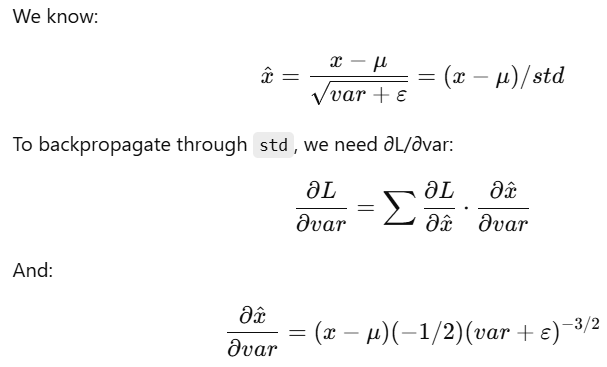

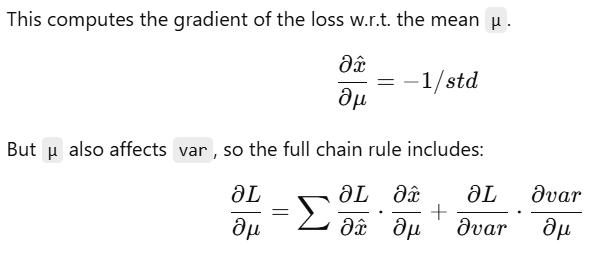

In [2]:
import numpy as np

class BatchNorm1D:
  def __init__(self,dim ,eps = 1e-5 ,momentum =0.9):
    self.dim = dim
    self.eps = eps
    self.momentum = momentum
    self.gamma = np.ones((1,dim)) # default initialization
    self.beta = np.zeros((1,dim))
    self.running_mean = np.zeros((1,dim))
    self.running_var = np.ones((1,dim))
    self.dgamma = np.zeros_like(self.gamma)
    self.dbeta = np.zeros_like(self.beta)

  def forward(self,x,training = True):
    self.x = x
    if training:
      self.mu = np.mean(x,axis=0,keepdims = True)
      self.var = np.var(x,axis=0,keepdims = True)
      self.std = np.sqrt(self.var + self.eps)
      self.x_hat = (x - self.mu)/self.std
      # exponential moving average
      self.running_mean = self.momentum * self.running_mean + (1-self.momentum)*self.mu
      self.running_var = self.momentum * self.running_var + (1-self.momentum)*self.var
      #An Exponential Moving Average (EMA) is a type of moving average
      #that gives more weight to recent prices, making it more responsive to price changes
      #than a Simple Moving Average (SMA)
    else :
      self.x_hat = (x -self.running_mean)/np.sqrt(self.running_var + self.eps)
    # normalising might distort some useful signal so we restore some flexibility
    out = self.gamma * self.x_hat + self.beta
    return out

  def backward(self,dout):
    N,D = self.x.shape
    self.dbeta = np.sum(dout,axis=0,keepdims =True) # since do_db = 1 gradient accumulate over batch
    self.dgamma =np.sum(dout*self.x_hat,axis=0,keepdims=True)  # Acuumulate over batch
    dx_hat = dout * self.gamma
    dvar = np.sum(dx_hat *(self.x - self.mu)* -0.5*(self.std**-3),axis=0,keepdims=True)
    dmu = np.sum(dx_hat*-1/self.std,axis=0,keepdims=True)+dvar*np.mean(-2*(self.x-self.mu),axis =0,keepdims=True)
    dx = dx_hat * -1/self.std + dvar *2*(self.x - self.mu)/N+dmu/N
    return dx

  def zero_grad(self):
    self.dgamma.fill(0)
    self.dbeta.fill(0)

# BatchNorm2D

In [3]:
import numpy as np

class BatchNorm2D:
    def __init__(self, num_channels, eps=1e-5, momentum=0.9):
        self.num_channels = num_channels
        self.eps = eps
        self.momentum = momentum
        self.gamma = np.ones((1, num_channels, 1, 1))  # scale
        self.beta = np.zeros((1, num_channels, 1, 1))  # shift
        self.running_mean = np.zeros((1, num_channels, 1, 1))
        self.running_var = np.ones((1, num_channels, 1, 1))
        self.dgamma = np.zeros_like(self.gamma)
        self.dbeta = np.zeros_like(self.beta)

    def forward(self, x, training=True):
        self.x = x
        N, C, H, W = x.shape

        if training:
            # Compute mean and variance over (N, H, W)
            self.mu = np.mean(x, axis=(0, 2, 3), keepdims=True)
            self.var = np.var(x, axis=(0, 2, 3), keepdims=True)
            self.std = np.sqrt(self.var + self.eps)
            self.x_hat = (x - self.mu) / self.std
            # Update running statistics
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            self.x_hat = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)

        out = self.gamma * self.x_hat + self.beta
        return out

    def backward(self, dout):
        N, C, H, W = dout.shape
        m = N * H * W
        # Gradients w.r.t. scale and shift
        self.dbeta = np.sum(dout, axis=(0, 2, 3), keepdims=True)
        self.dgamma = np.sum(dout * self.x_hat, axis=(0, 2, 3), keepdims=True)
        dx_hat = dout * self.gamma
        dvar = np.sum(dx_hat * (self.x - self.mu) * -0.5 * (self.std ** -3), axis=(0, 2, 3), keepdims=True)
        dmu = np.sum(dx_hat * -1 / self.std, axis=(0, 2, 3), keepdims=True) + dvar * np.mean(-2 * (self.x - self.mu), axis=(0, 2, 3), keepdims=True)
        dx = dx_hat / self.std + dvar * 2 * (self.x - self.mu) / m + dmu / m
        return dx

    def zero_grad(self):
        self.dgamma.fill(0)
        self.dbeta.fill(0)
